In [30]:
from google.colab import files
from pyspark.sql import SparkSession

uploaded = files.upload()

Saving clean_student_performance_final1.csv to clean_student_performance_final1 (1).csv


In [31]:
!ls

'clean_student_performance_final1 (1).csv'   sample_data
 clean_student_performance_final1.csv


In [32]:

spark = SparkSession.builder.appName("StudentPerformanceVisualization").getOrCreate()

file_path = "/content/clean_student_performance_final1.csv"

df = spark.read.option("header", True).option("inferSchema", True).csv(file_path)

df.printSchema()
df.show(5)

root
 |-- student_id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- grade_level: string (nullable = true)
 |-- subject_name: string (nullable = true)
 |-- teacher_name: string (nullable = true)
 |-- difficulty_level: string (nullable = true)
 |-- hours_per_week: integer (nullable = true)
 |-- description: string (nullable = true)
 |-- month: string (nullable = true)
 |-- score: double (nullable = true)
 |-- sleep_hours: double (nullable = true)
 |-- study_hours: double (nullable = true)
 |-- attendance_rate: integer (nullable = true)
 |-- internet_access: integer (nullable = true)
 |-- free_time_activity: string (nullable = true)
 |-- parent_education: string (nullable = true)
 |-- homework_completion_rate: integer (nullable = true)
 |-- extracurricular_activities: integer (nullable = true)
 |-- family_size: integer (nullable = true)
 |-- previous_gpa: double (nullable = true)
 |-- school_tra

In [33]:
# ============================================================
# Step 3️⃣ : Analyze and Trend Scores Over Time
# ============================================================

from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1️⃣ - Check for required columns
if "score" in df.columns and "date" in df.columns:
    # 2️⃣ - Calculate the average score for each date
    score_trend = (
        df.groupBy("date")
          .agg(F.avg("score").alias("average_score"))
          .orderBy("date")
    )

    # 3️⃣ - Convert to pandas for plotting
    pdf_trend = score_trend.toPandas()

    # 4️⃣ - Plot the trend over time
    plt.figure(figsize=(10,5))
    sns.lineplot(data=pdf_trend, x="date", y="average_score", marker="o")
    plt.title("📈 Average Student Score Over Time", fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Average Score")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

else:
    print("⚠ Missing 'score' or 'date' columns in the data. Please check the names after cleaning.")

⚠ Missing 'score' or 'date' columns in the data. Please check the names after cleaning.


In [7]:
# ============================================================
# Display column names present in the data after cleaning
# ============================================================

print("📋 Columns available in the file:")
for col in df.columns:
    print("-", col)

📋 Columns available in the file:
- student_id
- name
- age
- gender
- grade_level
- subject_name
- teacher_name
- difficulty_level
- hours_per_week
- description
- month
- score
- sleep_hours
- study_hours
- attendance_rate
- internet_access
- free_time_activity
- parent_education
- homework_completion_rate
- extracurricular_activities
- family_size
- previous_gpa
- school_transport
- health_condition
- tutoring
- admission_year
- city
- country
- scholarship_status
- exam_attempts
- teacher_experience_years
- parent_income
- feedback_rating
- efficiency
- performance_level


/tmp/ipython-input-2705730407.py:35: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.



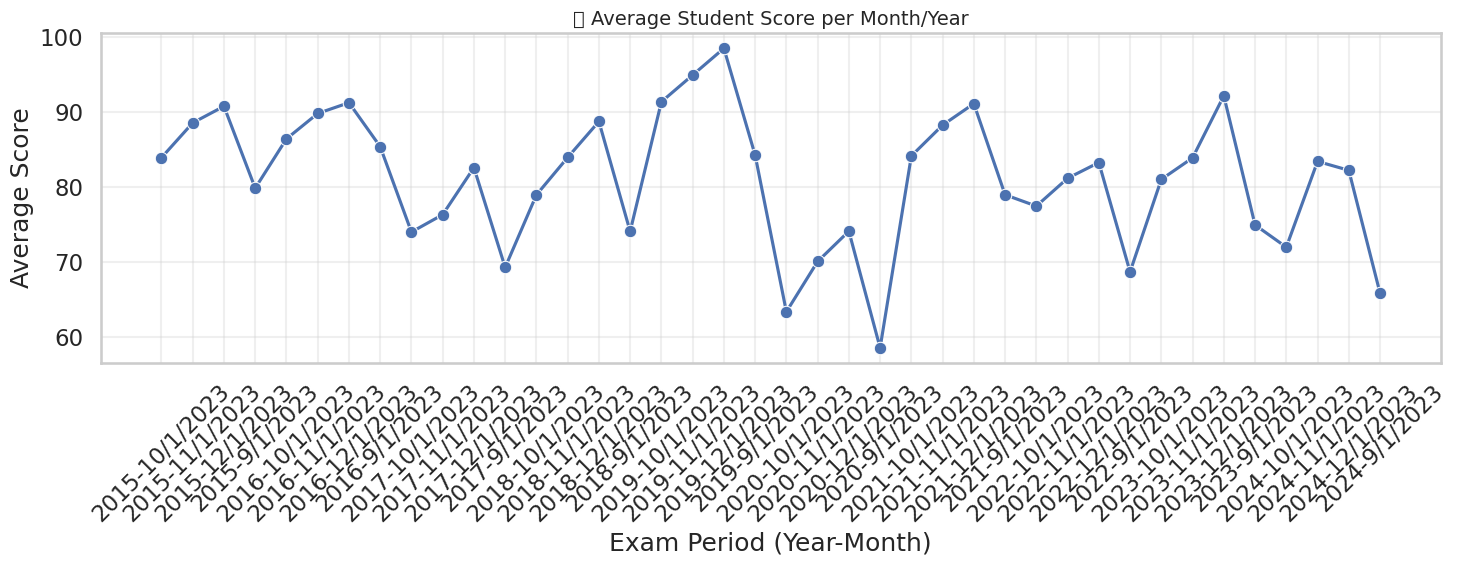

In [58]:
# ============================================================
# Step 3️⃣: Analyze Score Trend by Month and Year
# ============================================================

from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1️⃣ - Create a column representing the time period (e.g., 2024-Jan)
# Assumes 'df' is your PySpark DataFrame and 'month' and 'admission_year' columns exist.
df = df.withColumn(
    "exam_period",
    F.concat_ws("-", F.col("admission_year").cast("string"), F.col("month"))
)

# 2️⃣ - Calculate the average score for each period
score_trend = (
    df.groupBy("exam_period")
      .agg(F.avg("score").alias("average_score"))
      .orderBy("exam_period")
)

# 3️⃣ - Convert the data to pandas for plotting
pdf_trend = score_trend.toPandas()

# 4️⃣ - Plot the trend over time
plt.figure(figsize=(15,6))
sns.lineplot(data=pdf_trend, x="exam_period", y="average_score", marker="o")
plt.title("📈 Average Student Score per Month/Year", fontsize=14)
plt.xlabel("Exam Period (Year-Month)")
plt.ylabel("Average Score")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

/tmp/ipython-input-3317507972.py:36: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-3317507972.py:36: UserWarning:

Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14

/tmp/ipython-input-3317507972.py:54: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/tmp/ipython-input-3317507972.py:65: UserWarning:

Glyph 127752 (\N{RAINBOW}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 127752 (\N{RAINBOW}) missing from font(s) DejaVu Sans.



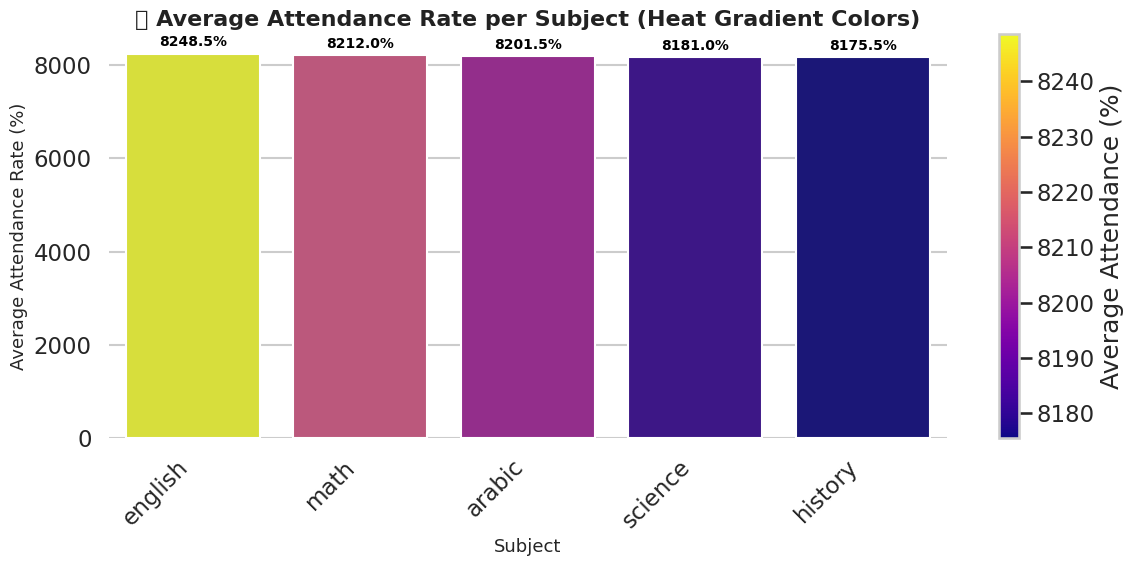

In [36]:
# ============================================================
# Step 4️⃣ : Average Attendance Rate per Subject — Heat Gradient Colors
# ============================================================

from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib as mpl

# 1️⃣ - Aggregate average attendance per subject
attendance_by_subject = (
    df.groupBy("subject_name")
      .agg(F.avg("attendance_rate").alias("avg_attendance_rate"))
      .orderBy("avg_attendance_rate", ascending=False)
)

# 2️⃣ - Convert to Pandas
pdf_attendance = attendance_by_subject.toPandas()
pdf_attendance["avg_attendance_rate"] = pdf_attendance["avg_attendance_rate"] * 100

# 3️⃣ - Set style
sns.set(style="whitegrid", context="talk")

# 4️⃣ - Create color mapping based on values
cmap = mpl.cm.plasma
norm = mpl.colors.Normalize(vmin=pdf_attendance["avg_attendance_rate"].min(),
                            vmax=pdf_attendance["avg_attendance_rate"].max())

bar_colors = cmap(norm(pdf_attendance["avg_attendance_rate"].values))

# 5️⃣ - Create figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# 6️⃣ - Plot bars
bar_plot = sns.barplot(
    data=pdf_attendance,
    x="subject_name",
    y="avg_attendance_rate",
    palette=bar_colors,
    dodge=False,
    ax=ax
)

# 7️⃣ - Add colorbar
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label="Average Attendance (%)")  # استخدام ax هنا

# 8️⃣ - Titles and labels
ax.set_title("🌈 Average Attendance Rate per Subject (Heat Gradient Colors)", fontsize=16, weight="bold", color="#222")
ax.set_xlabel("Subject", fontsize=13)
ax.set_ylabel("Average Attendance Rate (%)", fontsize=13)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

# 9️⃣ - Annotate values on bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha="center", va="center",
                xytext=(0, 8), textcoords="offset points",
                fontsize=10, color="black", fontweight="bold")

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.



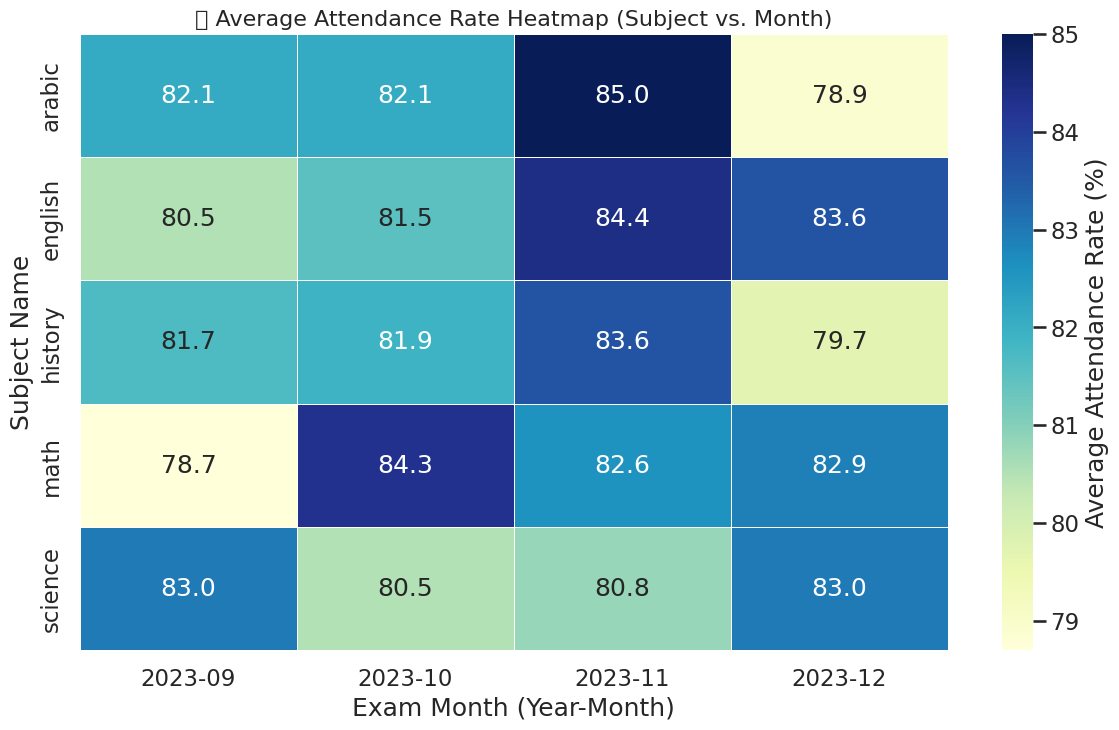

In [37]:
# ============================================================
# 🎯 Detailed Attendance Heatmap (Subject vs. Month)
# ============================================================

# 1️⃣ - Ensure the month is sortable (if not already done)
# Note: Assuming 'df' is your PySpark DataFrame
df_hm = df.withColumn("month_sort", F.to_date(F.col("month"), "M/d/yyyy"))

# 2️⃣ - Calculate the average attendance for each Subject-Month combination
attendance_heatmap_data = (
    df_hm.groupBy("subject_name", F.date_format("month_sort", "yyyy-MM").alias("sortable_month"))
    .agg(F.round(F.avg("attendance_rate"), 1).alias("avg_attendance"))
    .orderBy("subject_name", "sortable_month")
)

# 3️⃣ - Convert to Pandas and Pivot the data
pdf_heatmap = attendance_heatmap_data.toPandas()

# Create the pivot table: Subjects (rows) vs. Months (columns)
heatmap_pivot = pdf_heatmap.pivot_table(
    index="subject_name",
    columns="sortable_month",
    values="avg_attendance"
)

# 4️⃣ - Plotting the Heatmap using Seaborn
plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_pivot,
    annot=True,              # Show the average attendance value
    fmt=".1f",               # Format the numbers to one decimal place
    cmap="YlGnBu",           # Color palette
    linewidths=.5,           # Lines between cells
    cbar_kws={'label': 'Average Attendance Rate (%)'}
)

plt.title("🔥 Average Attendance Rate Heatmap (Subject vs. Month)", fontsize=16)
plt.xlabel("Exam Month (Year-Month)")
plt.ylabel("Subject Name")
plt.show()

📈 Pearson Correlation Matrix:
                             score  study_hours  sleep_hours  attendance_rate  \
score                     1.000000    -0.028924    -0.031336        -0.004089   
study_hours              -0.028924     1.000000     0.068651        -0.024995   
sleep_hours              -0.031336     0.068651     1.000000        -0.037279   
attendance_rate          -0.004089    -0.024995    -0.037279         1.000000   
homework_completion_rate  0.185964     0.119022     0.005640        -0.052803   

                          homework_completion_rate  
score                                     0.185964  
study_hours                               0.119022  
sleep_hours                               0.005640  
attendance_rate                          -0.052803  
homework_completion_rate                  1.000000  


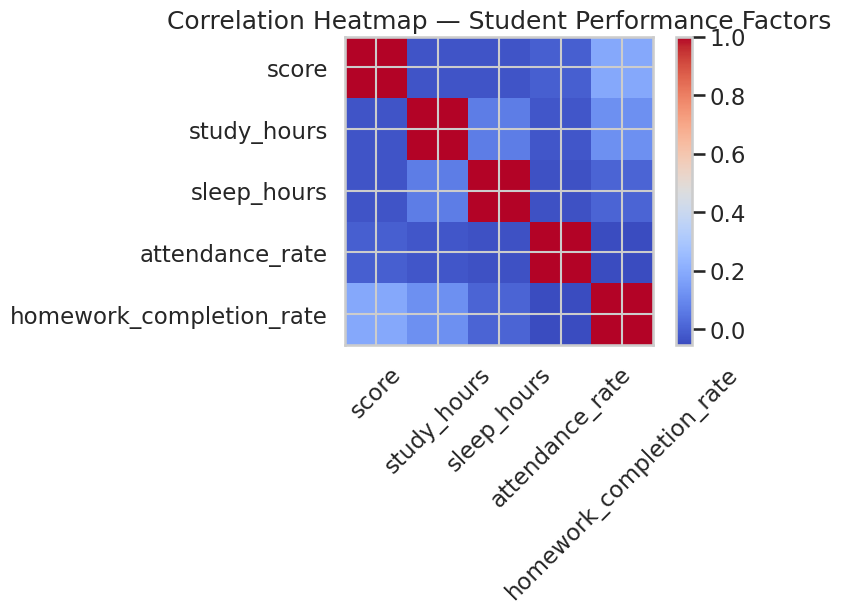


🎯 Correlation with Exam Score:
   study_hours: -0.029
   sleep_hours: -0.031
   attendance_rate: -0.004
   homework_completion_rate: 0.186


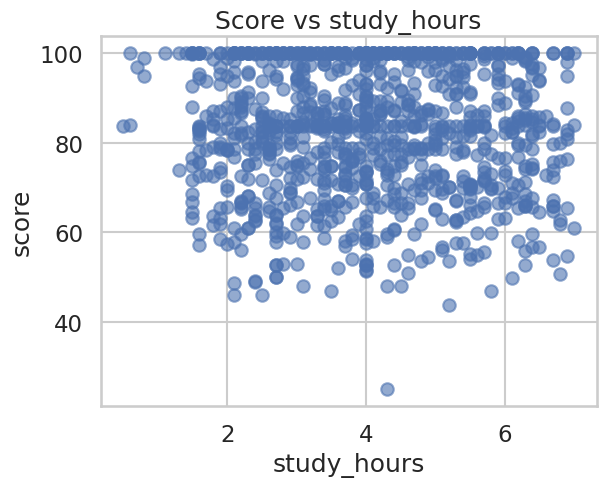

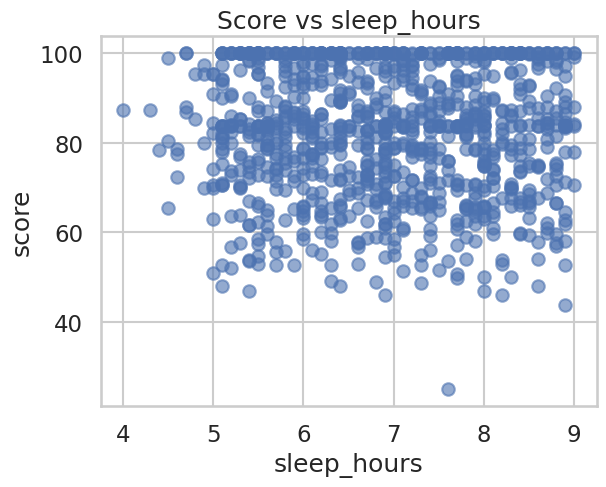

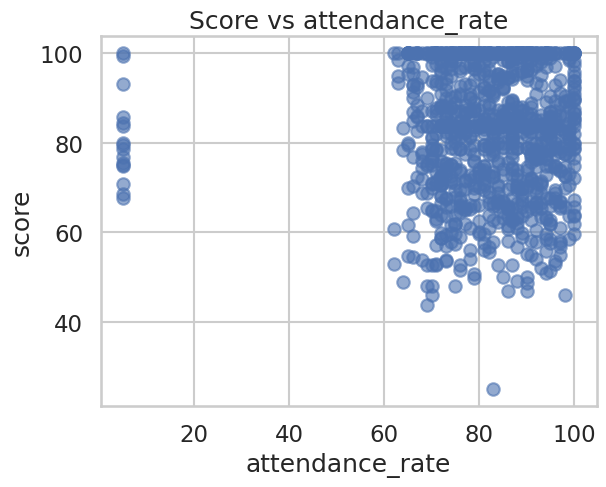

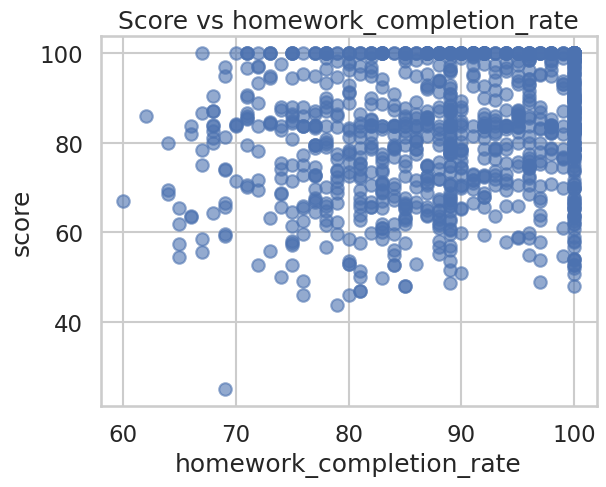

In [38]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd

# Convert to pandas for easier plotting (since dataset is small)
pandas_df = df.select("score", "study_hours", "sleep_hours", "attendance_rate", "homework_completion_rate").toPandas()

# 1️⃣ Compute Pearson correlations between numeric columns
correlation_matrix = pandas_df.corr(method="pearson")
print("📈 Pearson Correlation Matrix:")
print(correlation_matrix)

# 2️⃣ Plot correlation heatmap (for visual clarity)
plt.figure(figsize=(6,4))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns)
plt.title("Correlation Heatmap — Student Performance Factors")
plt.show()

# 3️⃣ Focused correlations with score
print("\n🎯 Correlation with Exam Score:")
for col in ["study_hours", "sleep_hours", "attendance_rate", "homework_completion_rate"]:
    corr_val = pandas_df["score"].corr(pandas_df[col])
    print(f"   {col}: {corr_val:.3f}")

# 4️⃣ Visual exploration: scatter plots for major factors
cols_to_plot = ["study_hours", "sleep_hours", "attendance_rate", "homework_completion_rate"]
for c in cols_to_plot:
    plt.figure()
    plt.scatter(pandas_df[c], pandas_df["score"], alpha=0.6)
    plt.xlabel(c)
    plt.ylabel("score")
    plt.title(f"Score vs {c}")
    plt.show()

In [39]:
# 1️⃣ Compute Pearson correlations between numeric columns
correlation_matrix = pandas_df.corr(method="pearson")
print("📈 Pearson Correlation Matrix:")
print(correlation_matrix)

📈 Pearson Correlation Matrix:
                             score  study_hours  sleep_hours  attendance_rate  \
score                     1.000000    -0.028924    -0.031336        -0.004089   
study_hours              -0.028924     1.000000     0.068651        -0.024995   
sleep_hours              -0.031336     0.068651     1.000000        -0.037279   
attendance_rate          -0.004089    -0.024995    -0.037279         1.000000   
homework_completion_rate  0.185964     0.119022     0.005640        -0.052803   

                          homework_completion_rate  
score                                     0.185964  
study_hours                               0.119022  
sleep_hours                               0.005640  
attendance_rate                          -0.052803  
homework_completion_rate                  1.000000  


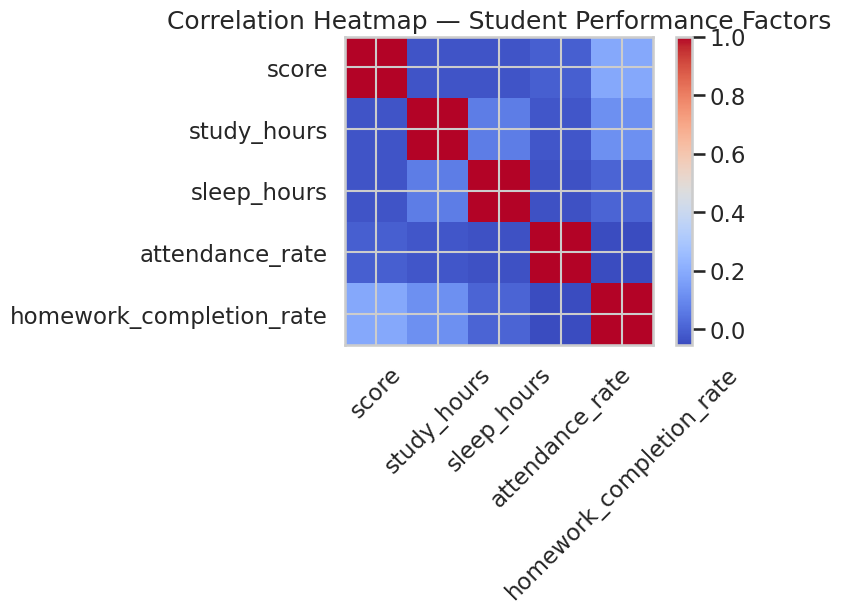

In [40]:
# 2️⃣ Plot correlation heatmap (for visual clarity)
plt.figure(figsize=(6,4))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns)
plt.title("Correlation Heatmap — Student Performance Factors")
plt.show()


In [41]:
# 3️⃣ Focused correlations with score
print("\n🎯 Correlation with Exam Score:")
for col in ["study_hours", "sleep_hours", "attendance_rate", "homework_completion_rate"]:
    corr_val = pandas_df["score"].corr(pandas_df[col])
    print(f"   {col}: {corr_val:.3f}")


🎯 Correlation with Exam Score:
   study_hours: -0.029
   sleep_hours: -0.031
   attendance_rate: -0.004
   homework_completion_rate: 0.186


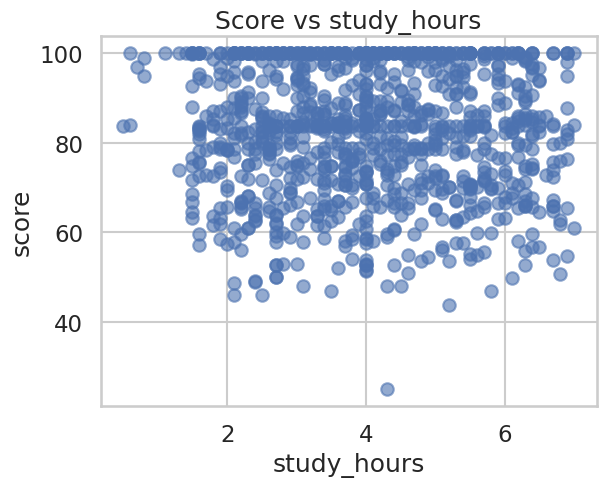

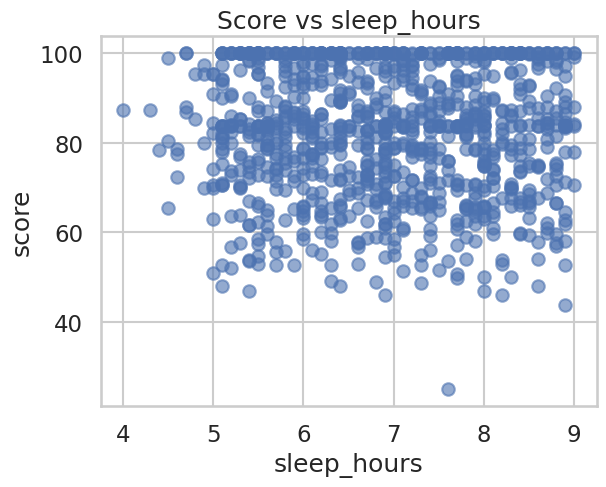

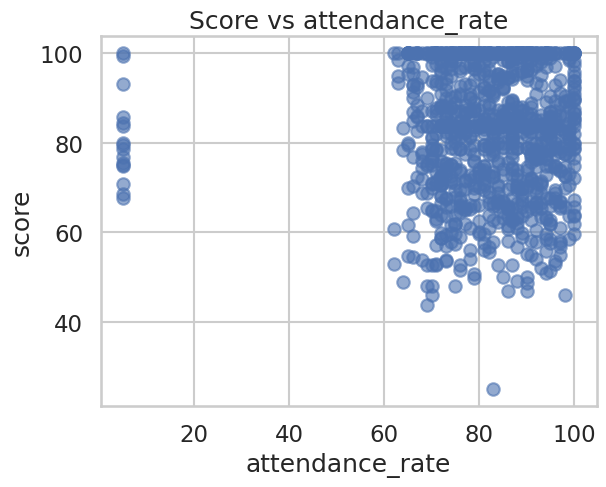

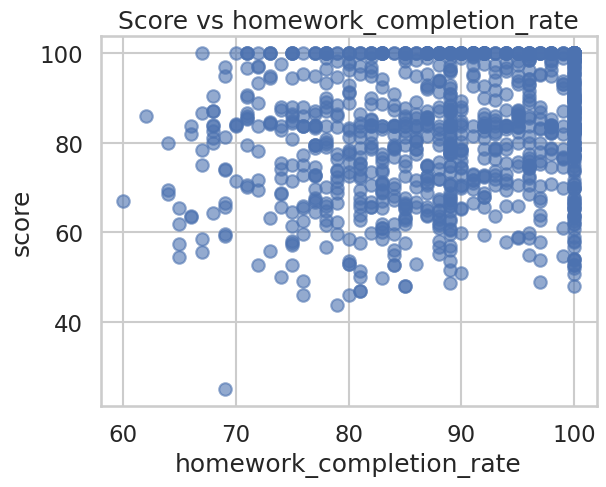

In [42]:
# 4️⃣ Visual exploration: scatter plots for major factors
cols_to_plot = ["study_hours", "sleep_hours", "attendance_rate", "homework_completion_rate"]
for c in cols_to_plot:
    plt.figure()
    plt.scatter(pandas_df[c], pandas_df["score"], alpha=0.6)
    plt.xlabel(c)
    plt.ylabel("score")
    plt.title(f"Score vs {c}")
    plt.show()

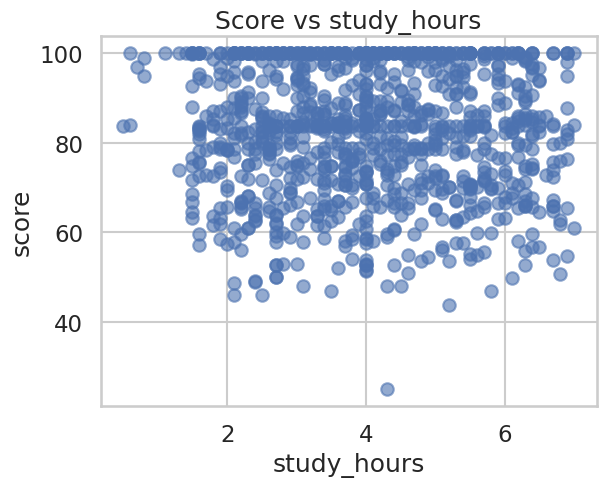

In [43]:
# 4️⃣ Visual exploration: scatter plots for major factors
plt.figure()
plt.scatter(pandas_df["study_hours"], pandas_df["score"], alpha=0.6)
plt.xlabel("study_hours")
plt.ylabel("score")
plt.title(f"Score vs study_hours")
plt.show()

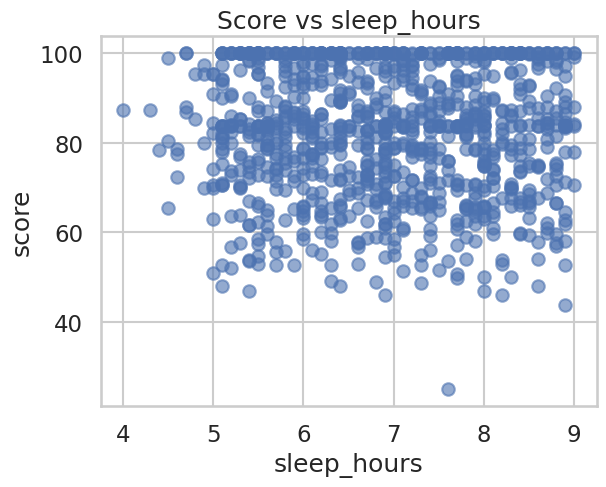

In [44]:
# 4️⃣ Visual exploration: scatter plots for major factors
plt.figure()
plt.scatter(pandas_df["sleep_hours"], pandas_df["score"], alpha=0.6)
plt.xlabel("sleep_hours")
plt.ylabel("score")
plt.title(f"Score vs sleep_hours")
plt.show()

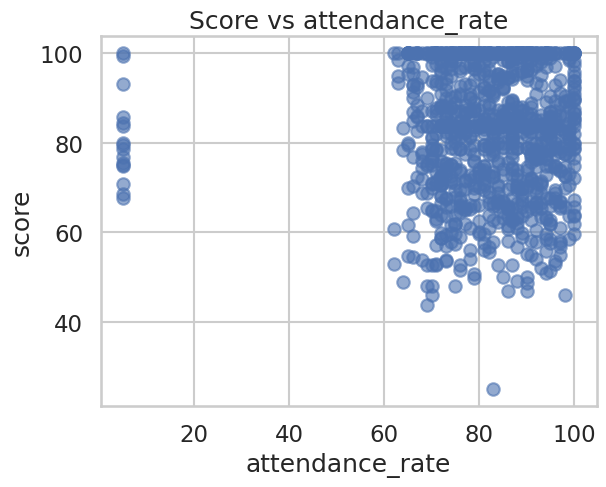

In [45]:
# 4️⃣ Visual exploration: scatter plots for major factors
plt.figure()
plt.scatter(pandas_df["attendance_rate"], pandas_df["score"], alpha=0.6)
plt.xlabel("attendance_rate")
plt.ylabel("score")
plt.title(f"Score vs attendance_rate")
plt.show()

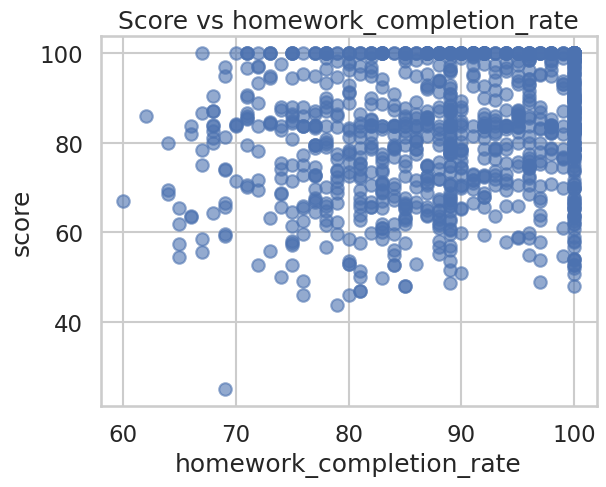

In [46]:
# 4️⃣ Visual exploration: scatter plots for major factors
plt.figure()
plt.scatter(pandas_df["homework_completion_rate"], pandas_df["score"], alpha=0.6)
plt.xlabel("homework_completion_rate")
plt.ylabel("score")
plt.title(f"Score vs homework_completion_rate")
plt.show()

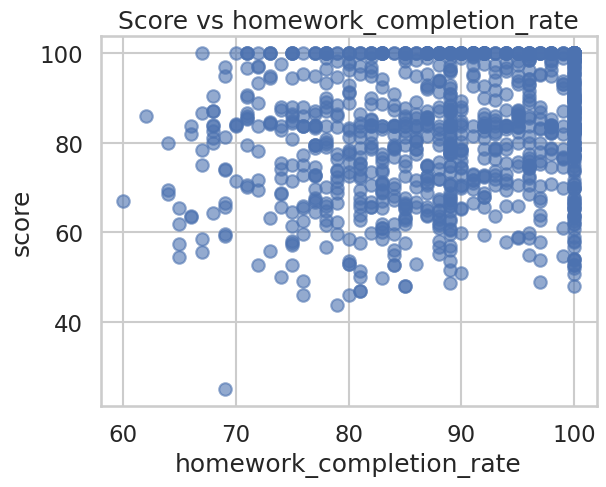

In [47]:
# 4️⃣ Visual exploration: scatter plots for major factors
plt.figure()
plt.scatter(pandas_df["homework_completion_rate"], pandas_df["score"], alpha=0.6)
plt.xlabel("homework_completion_rate")
plt.ylabel("score")
plt.title(f"Score vs homework_completion_rate")
plt.show()

In [48]:
# STEP 1: Average Exam Score by Subject

from pyspark.sql import functions as F
import plotly.express as px

# 1️⃣ Group by subject_name and calculate average score
avg_by_subject = (
    df.groupBy("subject_name")
      .agg(
          F.count("*").alias("records_count"),
          F.round(F.avg("score"), 2).alias("avg_score")
      )
      .orderBy(F.desc("avg_score"))
)

# 2️⃣ Convert to pandas for visualization
pdf_subject = avg_by_subject.toPandas()

# 3️⃣ Optional: filter out subjects with very few records (less reliable averages)
pdf_subject = pdf_subject[pdf_subject["records_count"] >= 3]

# 4️⃣ Sort by average score descending
pdf_subject = pdf_subject.sort_values("avg_score", ascending=False)

# 5️⃣ Plot bar chart
fig = px.bar(
    pdf_subject,
    x="subject_name",
    y="avg_score",
    color="avg_score",
    hover_data=["records_count"],
    title="Average Exam Score by Subject",
    labels={"subject_name": "Subject", "avg_score": "Average Score"}
)

fig.update_layout(
    title_x=0.5,
    template="plotly_white",
    xaxis_tickangle=45
)

fig.show()

In [49]:
# STEP 2: Relation between Study Hours and Exam Score

from pyspark.sql import functions as F
import plotly.express as px

# 1️⃣ Select the needed columns
study_score_df = df.select("study_hours", "score", "difficulty_level")

# 2️⃣ Convert to pandas for visualization (sample if data is large)
pdf_study_score = study_score_df.toPandas()

# Optional: if you have thousands of rows, sample 2000 for faster plotting
if len(pdf_study_score) > 2000:
    pdf_study_score = pdf_study_score.sample(2000, random_state=42)

# 3️⃣ Scatter plot
fig = px.scatter(
    pdf_study_score,
    x="study_hours",
    y="score",
    color="difficulty_level",  # color by difficulty (optional)
    title="Study Hours vs Exam Score",
    labels={"study_hours": "Study Hours", "score": "Exam Score"},
    opacity=0.7,
    trendline="ols"  # add regression line (trendline)
)

# 4️⃣ Layout and style
fig.update_layout(
    title_x=0.5,
    template="plotly_white",
    hovermode="closest"
)

fig.show()

In [50]:
# STEP 3: Relation between Sleep Hours and Exam Score

from pyspark.sql import functions as F
import plotly.express as px

# 1️⃣ Select needed columns
sleep_score_df = df.select("sleep_hours", "score", "health_condition")

# 2️⃣ Convert to Pandas for visualization
pdf_sleep_score = sleep_score_df.toPandas()

# Optional sampling for large data
if len(pdf_sleep_score) > 2000:
    pdf_sleep_score = pdf_sleep_score.sample(2000, random_state=42)

# 3️⃣ Scatter plot
fig = px.scatter(
    pdf_sleep_score,
    x="sleep_hours",
    y="score",
    color="health_condition",  # color by health condition
    title="Sleep Hours vs Exam Score",
    labels={"sleep_hours": "Sleep Hours (Night Before Exam)", "score": "Exam Score"},
    opacity=0.7,
    trendline="ols"  # regression line
)

# 4️⃣ Layout and style
fig.update_layout(
    title_x=0.5,
    template="plotly_white",
    hovermode="closest"
)

fig.show()

In [51]:
# STEP 4: Attendance Rate vs Average Exam Score

from pyspark.sql import functions as F
import plotly.express as px

# 1️⃣ Group by attendance_rate (rounded to nearest 10%)
df_attendance = (
    df.withColumn("attendance_group", (F.col("attendance_rate") / 10).cast("int") * 10)
      .groupBy("attendance_group")
      .agg(F.avg("score").alias("avg_score"))
      .orderBy("attendance_group")
)

# 2️⃣ Convert to pandas
pdf_attendance = df_attendance.toPandas()

# 3️⃣ Bar chart
fig = px.bar(
    pdf_attendance,
    x="attendance_group",
    y="avg_score",
    title="Attendance Rate vs Average Exam Score",
    labels={"attendance_group": "Attendance Rate (%)", "avg_score": "Average Exam Score"},
    text_auto=".2f"
)

# 4️⃣ Style
fig.update_layout(
    title_x=0.5,
    template="plotly_white",
    xaxis=dict(dtick=10),
    yaxis=dict(range=[0, 100])
)

fig.show()

In [52]:
# STEP 5: Homework Completion Rate vs Average Exam Score

from pyspark.sql import functions as F
import plotly.express as px

# 1️⃣ Group by homework_completion_rate (rounded to nearest 10%)
df_homework = (
    df.withColumn("homework_group", (F.col("homework_completion_rate") / 10).cast("int") * 10)
      .groupBy("homework_group")
      .agg(F.avg("score").alias("avg_score"))
      .orderBy("homework_group")
)

# 2️⃣ Convert to Pandas
pdf_homework = df_homework.toPandas()

# 3️⃣ Bar chart
fig = px.bar(
    pdf_homework,
    x="homework_group",
    y="avg_score",
    title="Homework Completion Rate vs Average Exam Score",
    labels={"homework_group": "Homework Completion Rate (%)", "avg_score": "Average Exam Score"},
    text_auto=".2f"
)

# 4️⃣ Style and layout
fig.update_layout(
    title_x=0.5,
    template="plotly_white",
    xaxis=dict(dtick=10),
    yaxis=dict(range=[0, 100])
)

fig.show()

In [53]:
# STEP 6: Health Condition vs Average Exam Score

from pyspark.sql import functions as F
import plotly.express as px

# 1️⃣ Group by health_condition
df_health = (
    df.groupBy("health_condition")
      .agg(F.avg("score").alias("avg_score"))
      .orderBy("health_condition")
)

# 2️⃣ Convert to Pandas for visualization
pdf_health = df_health.toPandas()

# 3️⃣ Bar chart
fig = px.bar(
    pdf_health,
    x="health_condition",
    y="avg_score",
    title="Health Condition vs Average Exam Score",
    labels={"health_condition": "Health Condition", "avg_score": "Average Exam Score"},
    text_auto=".2f",
    color="health_condition"
)

# 4️⃣ Style and layout
fig.update_layout(
    title_x=0.5,
    template="plotly_white",
    showlegend=False,
    yaxis=dict(range=[0, 100])
)

fig.show()

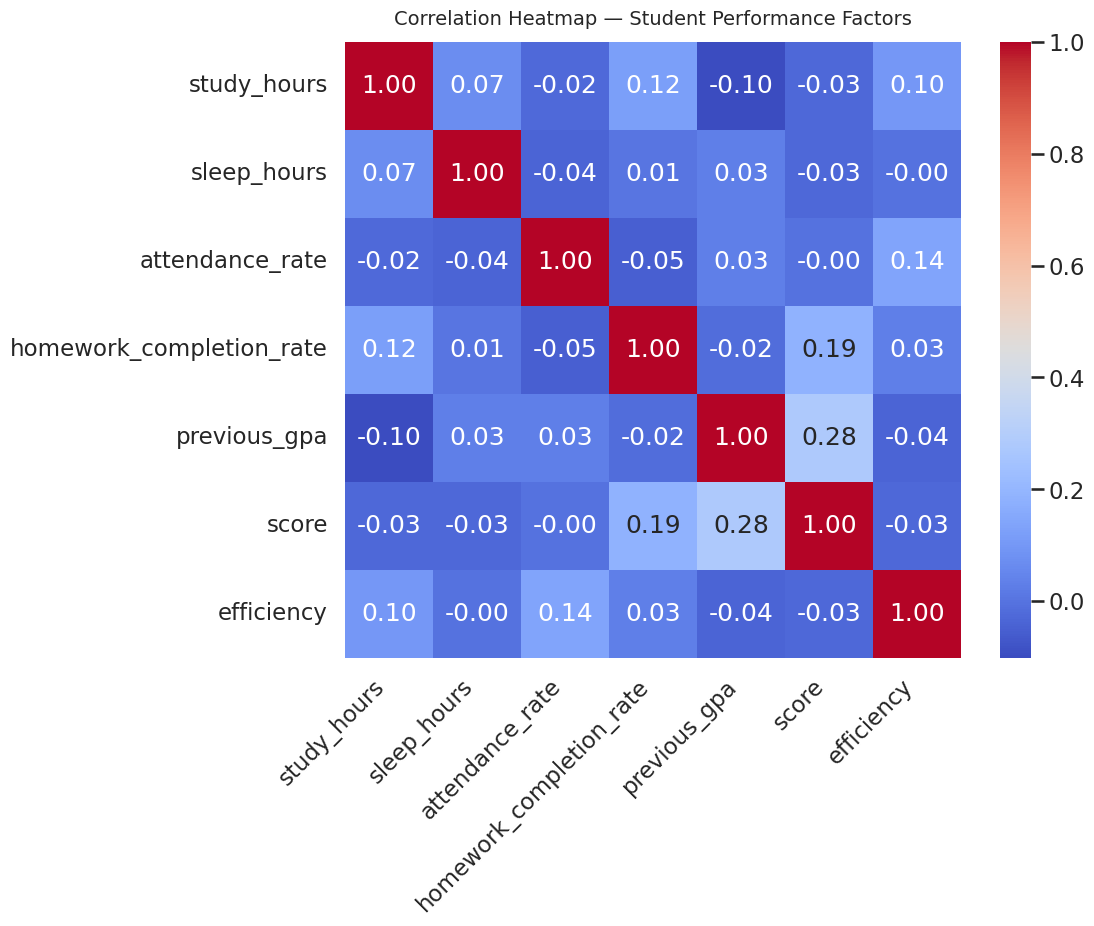

In [54]:
# STEP 7: Correlation Heatmap between numeric variables

import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

# 1️⃣ Select numeric columns (you can adjust this list)
numeric_cols = [
    "study_hours", "sleep_hours", "attendance_rate",
    "homework_completion_rate", "previous_gpa",
    "score", "efficiency"
]

# 2️⃣ Convert to Pandas
pdf_corr = df.select(numeric_cols).toPandas()

# 3️⃣ Compute correlation matrix
corr_matrix = pdf_corr.corr()

# 4️⃣ Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,       # show correlation values
    fmt=".2f",
    cmap="coolwarm",  # color gradient
    square=True,
    cbar=True
)

plt.title("Correlation Heatmap — Student Performance Factors", fontsize=14, pad=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()